In [22]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import pymc
import pymc.Matplot as pmplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
rc={'font.size': 32, 'axes.labelsize': 32, 'legend.fontsize': 32.0,
    'axes.titlesize': 32, 'xtick.labelsize': 32, 'ytick.labelsize': 32}
sns.set_style(rc = rc)

In [66]:
columns = ["Match","Date","Radiant","Dire","Winner","Round","Game","Time","Radiant Score","Dire Score"]
df = pd.read_csv('ti5_data_clean.csv', names = columns, skiprows=1)

In [69]:
df_raw.head()

,Match,Date,Radiant,Dire,Winner,Round,Game,Time,Radiant Score,Dire Score
48,1674031017,07/30/15,VP 2,Empire,DIRE,Tiebreaker,3,42.87,9,14
49,1673941543,07/30/15,VP 2,Empire,DIRE,Tiebreaker,2,49.15,19,26
50,1673865688,07/30/15,Empire,VP 2,DIRE,Tiebreaker,1,39.78,11,36
51,1673815749,07/30/15,EHOME,CDEC,DIRE,Group Stage,2,43.77,15,28
52,1673789962,07/30/15,Empire,MVP HOT6,RADIANT,Group Stage,2,29.78,26,13


In [70]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 48 to 162
Data columns (total 10 columns):
Match            115 non-null int64
Date             115 non-null object
Radiant          115 non-null object
Dire             115 non-null object
Winner           115 non-null object
Round            115 non-null object
Game             115 non-null int64
Time             115 non-null float64
Radiant Score    115 non-null int64
Dire Score       115 non-null int64
dtypes: float64(1), int64(4), object(5)
memory usage: 9.9+ KB


In [71]:
# Need to combine both sets of team names for encoding
set(df_raw.Radiant.unique()) == set(df_raw.Dire.unique())

False

In [72]:
# Encode team names
teams = set(list(df_raw.Radiant.unique()) + list(df_raw.Dire.unique()))
team_dict = dict(zip(teams, range(len(teams))))

In [73]:
team_dict

{'C9': 7,
 'CDEC': 6,
 'EG': 5,
 'EHOME': 4,
 'Empire': 12,
 'Fnatic.MY': 0,
 'LGD.cn': 10,
 'MVP HOT6': 13,
 'MVP Phoenix': 1,
 'NaVi': 3,
 'Nb': 14,
 'Secret': 8,
 'VG': 2,
 'VP 2': 9,
 'coL 2': 11,
 'iG': 15}

In [74]:
team_lookup = dict((v,k) for k, v in team_dict.iteritems())

In [75]:
team_lookup

{0: 'Fnatic.MY',
 1: 'MVP Phoenix',
 2: 'VG',
 3: 'NaVi',
 4: 'EHOME',
 5: 'EG',
 6: 'CDEC',
 7: 'C9',
 8: 'Secret',
 9: 'VP 2',
 10: 'LGD.cn',
 11: 'coL 2',
 12: 'Empire',
 13: 'MVP HOT6',
 14: 'Nb',
 15: 'iG'}

In [124]:
df_raw.loc[:,'radiant_team_id'] = df_raw.Radiant.apply(lambda x: team_dict[x])
df_raw.loc[:,'dire_team_id'] = df_raw.Dire.apply(lambda x: team_dict[x])

In [78]:
df_raw.head()

,Match,Date,Radiant,Dire,Winner,Round,Game,Time,Radiant Score,Dire Score,radiant_team_id,dire_team_id
48,1674031017,07/30/15,VP 2,Empire,DIRE,Tiebreaker,3,42.87,9,14,9,12
49,1673941543,07/30/15,VP 2,Empire,DIRE,Tiebreaker,2,49.15,19,26,9,12
50,1673865688,07/30/15,Empire,VP 2,DIRE,Tiebreaker,1,39.78,11,36,12,9
51,1673815749,07/30/15,EHOME,CDEC,DIRE,Group Stage,2,43.77,15,28,4,6
52,1673789962,07/30/15,Empire,MVP HOT6,RADIANT,Group Stage,2,29.78,26,13,12,13


In [79]:
# Most of the time (this patch) top score wins so we'll use
# score differntial as a proxy for winning
winner = (df_raw.Winner == 'RADIANT').values
top_score = (df_raw['Radiant Score'] > df_raw['Dire Score']).values

np.mean([x == y for x,y in zip(winner, top_score)])

0.95652173913043481

In [67]:
df.Round.unique()

array(['Finals', 'LB Finals', 'UB Finals', 'LB Semifinals',
       'LB Quarterfinals', 'UB Semifinals', 'LB Round of 16',
       'UB Quarterfinals', 'LB Round of 32', 'Tiebreaker', 'Group Stage'], dtype=object)

In [123]:
#df_raw = df.query('Round in ["Tiebreaker", "Group Stage"]')
#df_raw = df.query('Round in ["Tiebreaker", "Group Stage", "UB QuarterFinals","LB Round of 32"]')
#df_raw = df.query('Round in ["Tiebreaker", "Group Stage", "UB QuarterFinals","LB Round of 32","UB Semifinals", "LB Round of 16"]')
df_raw = df.query('Round in ["Tiebreaker", "Group Stage", "UB QuarterFinals","LB Round of 32","UB Semifinals", "LB Round of 16","LB Quarterfinals", "LB Semifinals"]')

In [125]:
observed_radiant_score = df_raw['Radiant Score'].values
observed_dire_score = df_raw['Dire Score'].values
radiant_team = df_raw.radiant_team_id.values
dire_team = df_raw.dire_team_id.values
num_teams = len(teams)
num_games = len(df_raw)

# Initialize values with global means (optional)
att_starting_points = np.log(df_raw.groupby('dire_team_id')['Dire Score'].mean())
def_starting_points = -np.log(df_raw.groupby('dire_team_id')['Radiant Score'].mean())

# Hyperparam Priors
dire = pymc.Normal('dire',0, 0.0001, value = 0)
tau_att = pymc.Gamma('tau_att', 0.1, 0.1, value = 10)
tau_def = pymc.Gamma('tau_def', 0.1, 0.1, value = 10)
intercept = pymc.Normal('intercept',0, 0.0001, value = 0)

# team priors
atts_star = pymc.Normal('atts_star',
                        mu = 0,
                        tau = tau_att,
                        size=num_teams,
                        value=att_starting_points.values)
defs_star = pymc.Normal('defs_star',
                        mu = 0,
                        tau = tau_def,
                        size=num_teams,
                        value=def_starting_points.values)

# Model specification
@pymc.deterministic
def atts(atts_star = atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star = defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def dire_theta(dire_team = dire_team,
               radiant_team = radiant_team,
               dire = dire,
               atts = atts,
               defs = defs,
               intercept = intercept):
    return np.exp(intercept +
                  dire +
                  atts[dire_team] +
                  defs[radiant_team])

@pymc.deterministic
def radiant_theta(dire_team = dire_team,
                  radiant_team = radiant_team,
                  dire = dire,
                  atts = atts,
                  defs = defs,
                  intercept = intercept):
    return np.exp(intercept +
                  atts[radiant_team] +
                  defs[dire_team])

dire_score = pymc.Poisson('dire_score',
                          mu = dire_theta,
                          value = observed_dire_score,
                          observed = True)

radiant_score = pymc.Poisson('radiant_score',
                             mu = radiant_theta,
                             value = observed_radiant_score,
                             observed = True)

mcmc = pymc.MCMC([dire, intercept, tau_att, tau_def,
                  dire_theta, radiant_theta, atts_star,
                  defs_star, atts,defs, dire_score,
                  radiant_score])

In [126]:
mcmc.sample(250000, 80000, 20)

 [-----------------100%-----------------] 250000 of 250000 complete in 107.5 sec

In [127]:
atts_trace = atts.trace()
defs_trace = defs.trace()
dire_trace = dire.trace()
intercept_trace = intercept.trace()

Plotting dire
Plotting intercept
Plotting tau_att
Plotting tau_def


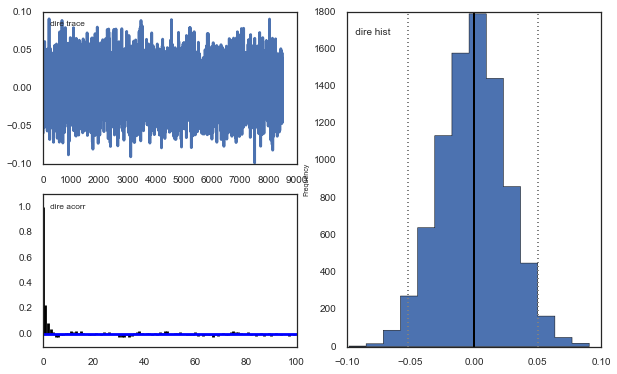

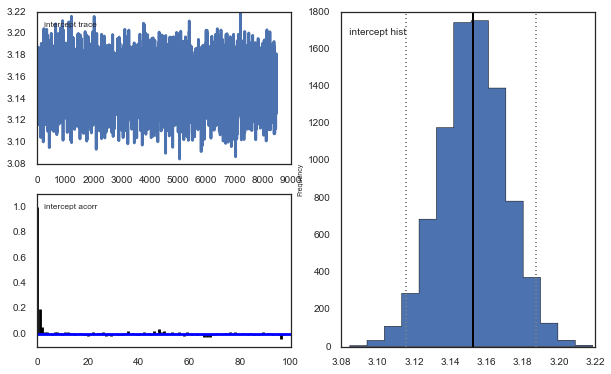

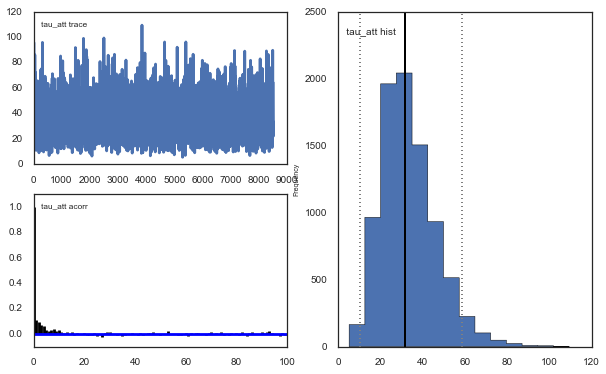

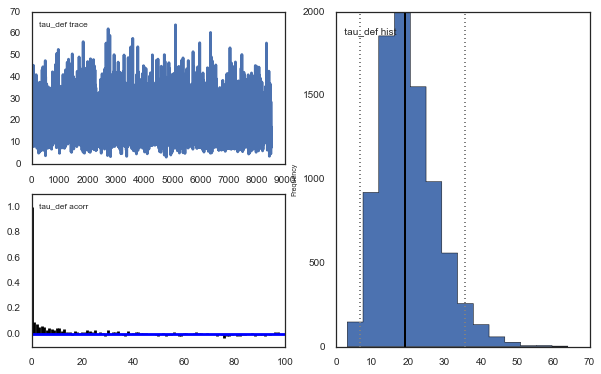

In [128]:
pmplot.plot(mcmc)

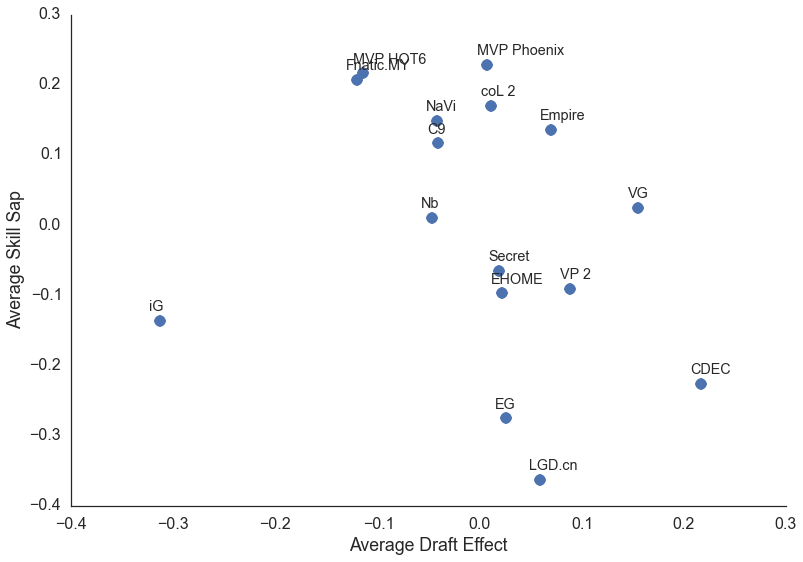

In [129]:
# Good way to look at team strength
df_avg = pd.DataFrame({'avg_att': atts.stats()['mean'],
                       'avg_def': defs.stats()['mean']},
                      index=sorted(team_dict,key =  team_dict.get))

fig, ax = plt.subplots()

ax.plot(df_avg.avg_att,df_avg.avg_def,'o')
for row in df_avg.iterrows():
    ax.annotate(row[0],xy=tuple(row[1]), xytext = (-10, 10), textcoords = 'offset points', fontsize = 'x-large')
plt.xlabel('Average Draft Effect')
plt.ylabel('Average Skill Sap')
sns.despine()

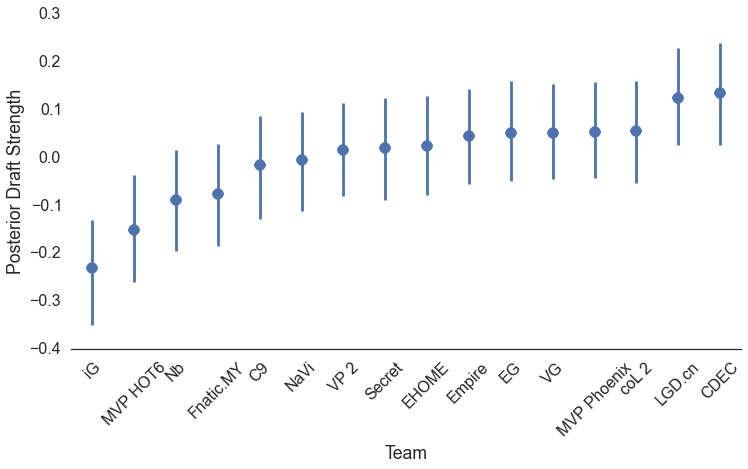

In [110]:
df_hpd = pd.DataFrame((atts.stats()['95% HPD interval']).T,
                      columns=['hpd_low','hpd_high'],
                      index=sorted(team_dict,key =  team_dict.get))

df_median = pd.DataFrame((atts.stats()['quantiles'][50]),
                      columns=['hpd_median'],
                      index=sorted(team_dict,key =  team_dict.get))

df_hpd = df_hpd.merge(df_median, left_index=True, right_index=True)
df_hpd.loc[:,'relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd.loc[:,'relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median

df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + 0.5
fig, axs = plt.subplots(figsize=(12,6))

axs.errorbar(df_hpd['x'],
            df_hpd.hpd_median,
            yerr=(df_hpd[['relative_lower','relative_upper']].values).T,
            fmt='o')

plt.xlabel('Team')
plt.ylabel('Posterior Draft Strength')
axs.set_xticks(df_hpd['x'])
axs.set_xticklabels(df_hpd['index'].values, rotation = 45)
sns.despine(left = True)

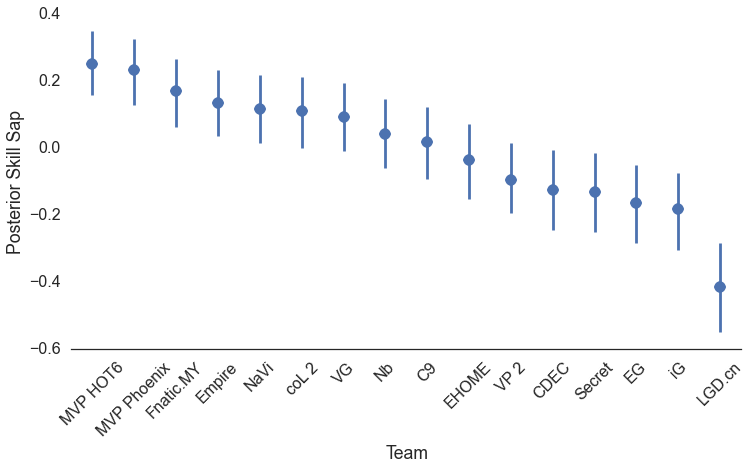

In [111]:
df_hpd = pd.DataFrame((defs.stats()['95% HPD interval']).T,
                      columns=['hpd_low','hpd_high'],
                      index=sorted(team_dict,key =  team_dict.get))

df_median = pd.DataFrame((defs.stats()['quantiles'][50]),
                      columns=['hpd_median'],
                      index=sorted(team_dict,key =  team_dict.get))

df_hpd = df_hpd.merge(df_median, left_index=True, right_index=True)
df_hpd.loc[:,'relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd.loc[:,'relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median

df_hpd = df_hpd.sort_index(by='hpd_median', ascending = False)
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + 0.5
fig, axs = plt.subplots(figsize=(12,6))

axs.errorbar(df_hpd['x'],
            df_hpd.hpd_median,
            yerr=(df_hpd[['relative_lower','relative_upper']].values).T,
            fmt='o')

plt.xlabel('Team')
plt.ylabel('Posterior Skill Sap')
axs.set_xticks(df_hpd['x'])
axs.set_xticklabels(df_hpd['index'].values, rotation = 45)
sns.despine(left = True)

In [120]:
#def get_dire_theta(intercept, dire, atts, defs):
#    return np.exp(intercept + dire + atts + defs)

def get_dire_theta(intercept, dire, atts, defs):
    return np.exp(intercept + dire + atts + defs)

def get_radiant_theta(intercept, atts, defs):
    return np.exp(intercept + atts + defs)

def get_score(theta):
    return np.random.poisson(theta)

In [121]:
from collections import Counter
import operator
from functools import partial

def simulate_match(dire_team,radiant_team,atts_t,defs_t,dire_t,int_t,draw = None):
    if draw == None:
        # draw samples
        num_samples = len(atts_t)
        draw = np.random.randint(0,num_samples)

    # draw for the given two teams
    dire_att = atts_t[draw,dire_team]
    radiant_att = atts_t[draw,radiant_team]
    dire_defs = defs_t[draw,dire_team]
    radiant_defs = defs_t[draw,radiant_team]
    
    intercept_draw = int_t[draw]
    dire_draw = dire_t[draw]
    
    # Collect latent strengths
    dire_thetas = get_dire_theta(intercept_draw,
                                 dire_draw,
                                 dire_att,
                                 radiant_defs)
    
    radiant_thetas = get_radiant_theta(intercept_draw,
                                        radiant_att,
                                        dire_defs)
    
    # Generate scores
    dire_scores = get_score(dire_thetas)
    radiant_scores = get_score(radiant_thetas)
    
    # Call a winner (probability dire wins)
    if dire_scores >= radiant_scores:
        return dire_team
    else:
        return radiant_team

def simulate_series(team_one, team_two, n,
                    atts_t,defs_t,dire_t,
                    int_t,draw = None):
    # flip to see who is dire
    dire_team = np.random.choice([team_one, team_two])
    if dire_team == team_one:
        radiant_team = team_two
    else:
        radiant_team = team_one
    
    winner = []
    for game in xrange(n):
        winner.append(simulate_match(dire_team, radiant_team,
                                     atts_t,defs_t,dire_t,
                                     int_t,draw = draw))
        dire_team, radiant_team = radiant_team, dire_team
        
    wins = Counter(winner)
    
    # find who won the most
    return max(wins.iteritems(), key=operator.itemgetter(1))[0]

def predict_winner(t1,t2,n, atts_t,
                   defs_t,dire_t,int_t,
                   draw = None, sims = 10000,disp = False):
    
    win_count = Counter([simulate_series(t1,t2,n,atts_t,
                                         defs_t,dire_t,int_t,
                                         draw = draw) for _ in xrange(sims)])
    
    win_team, num_wins = max(win_count.iteritems(), key=operator.itemgetter(1))
    if disp == True:
        print 'Team %d wins with probability %0.2f' % (win_team, num_wins / sims)
    return win_team


quick_win = partial(predict_winner, atts_t = atts_trace, defs_t = defs_trace, dire_t = dire_trace, int_t = intercept_trace)

In [89]:
games = [(10,12),(6,7),(1,14),(2,3),(9,0),(15,13)]

for g in games:
    quick_win(g[0],g[1],3, disp = True)

Team 10 wins with probability 1.00
Team 6 wins with probability 0.89
Team 14 wins with probability 0.69
Team 2 wins with probability 0.53
Team 9 wins with probability 0.91
Team 15 wins with probability 0.91


In [112]:
games = [(5,11),(8,4),(12,1),(7,2)]

for g in games:
    quick_win(g[0],g[1],3,disp = True)

Team 5 wins with probability 0.89
Team 8 wins with probability 0.65
Team 12 wins with probability 0.71
Team 7 wins with probability 0.59


In [122]:
games = [(11,9),(8,15),(10,6),(5,4)]

for g in games:
    quick_win(g[0],g[1],3,disp = True)

Team 9 wins with probability 0.96
Team 8 wins with probability 0.89
Team 6 wins with probability 0.61
Team 5 wins with probability 0.75


In [130]:
games = [(1,2),(9,8),(2,4)]

for g in games:
    quick_win(g[0],g[1],3,disp = True)

Team 2 wins with probability 0.93
Team 9 wins with probability 0.65
Team 4 wins with probability 0.65


In [93]:
games = [(10,9),(6,5), (2,10)]

for g in games:
    quick_win(g[0],g[1],3,disp = True)

Team 10 wins with probability 0.97
Team 6 wins with probability 0.57
Team 10 wins with probability 1.00


In [94]:
quick_win(10,5,3,disp = True)
_ = quick_win(10,6,3,disp = True)

Team 10 wins with probability 0.91
Team 10 wins with probability 0.88


In [95]:
from collections import defaultdict

def slot_dict(winner, loser, team_1 = None, team_2 = None):
    return {'winner':winner,
            'loser':loser,
            'team_1':team_1,
            'team_2':team_2}

def make_bracket_dict():
    '''
    Bracket start:
    LGD v. Empire (10:12)
    CDEC v. C9 (6:7)
    EG v. coL (5:11)
    Secret v. EHOME (8:4)

    MVP.Phx v. Newbee (1:14)
    VG v. Na'Vi (2:3)
    VP v. Fnatic (9:0)
    iG v. MVP.Hot6 (15:13)
    '''
    
    places = ['1','2','3','4','5-6','7-8','9-12','13-16']
    seed_spots = ['LB1A','LB1B','LB1C','LB1D',
                  'UB1A','UB1B','UB1C','UB1D']
    seed_tuples = [(1,14),(2,3),(9,0),(15,13),
                   (10,12),(6,7),(5,11),(8,4)]
    
    lower_bracket = [('LB1A','LB2A','13-16'),
                     ('LB1B','LB2B','13-16'),
                     ('LB1C','LB2C','13-16'),
                     ('LB1D','LB2D','13-16'),
                     ('LB2A','LB3A','9-12'), ('LB2B','LB3A','9-12'),
                     ('LB2C','LB3B','9-12'), ('LB2D','LB3B','9-12'),
                     ('LB3A','LB4A','7-8'),
                     ('LB3B','LB4B','7-8'),
                     ('LB4A','LB5A','5-6'), ('LB4B','LB5A','5-6'),
                     ('LB5A','LBF','4'),
                     ('LBF','GF','3')]
    
    upper_bracket = [('UB1A','UB2A','LB2A'),
                     ('UB1B','UB2A','LB2B'),
                     ('UB1C','UB2B','LB2C'),
                     ('UB1D','UB2B','LB2D'),
                     ('UB2A','UBF','LB4B'), ('UB2B','UBF','LB4A'),
                     ('UBF','GF','LBF'),('GF','1','2')]
    
    bracket_tuples = lower_bracket + upper_bracket
    
    bracket_dict = defaultdict(dict)
    
    for place in places:
        bracket_dict[place] = []
    
    for slot,winner,loser in bracket_tuples:
        bracket_dict[slot] = slot_dict(winner, loser)
        
    # Seed
    for teams, slot in zip(seed_tuples, seed_spots):
        bracket_dict[slot].update({'team_1':teams[0],'team_2':teams[1]})
    
    return bracket_dict

def send_team(team, slot, brack):
    # Is this a terminal bracket?
    if slot in ['1','2','3','4','5-6','7-8','9-12','13-16']:
        brack[slot].append(team)
    # check for the missing team
    elif brack[slot]['team_1'] == None:
        brack[slot].update({'team_1':team})
    else:
        brack[slot].update({'team_2':team})

    return brack
    

def simulate_bracket(draw = None):
    match_progression = ['UB1A','UB1B','LB1A','LB1B','LB1C','LB1D',
                         'UB1C','UB1D','LB2A','LB2B',
                         'LB2C','LB2D','UB2A','UB2B',
                         'LB3A','LB3B','LB4A',
                         'LB4B','UBF','LB5A',
                         'LBF','GF']
    # get starting bracket
    bracket = make_bracket_dict()
        
    n = 3
    for match in match_progression:
        # if this is Grand Finals make BO 5
        if match == 'GF':
            n = 5
        # Grab this match from bracket
        match_dict = bracket[match]
        # simulate match
        winner = quick_win(match_dict['team_1'],match_dict['team_2'], n = 3, sims = 1, draw = draw)
        if match_dict['team_1'] == winner:
            loser = match_dict['team_2']
        else:
            loser = match_dict['team_1']
        # Send the teams to the right places
        bracket = send_team(winner, match_dict['winner'], bracket)
        bracket = send_team(loser, match_dict['loser'], bracket)
        
    return bracket

def oracle(n_samples = 1000):
    '''
    simulates n_samples brackets and collects the placement counts for each team
    '''
    team_dict = defaultdict(list)
    places = ['1','2','3','4','5-6','7-8','9-12','13-16']
    
    for _ in xrange(n_samples):
        # seed this bracket
        draw = np.random.randint(0,len(atts_trace))
        curr_bracket = simulate_bracket(draw = draw)
        # go through finishing places and append place to team
        for place in places:
            for t in curr_bracket[place]:
                team_dict[t].append(place)
    
    for t, results in team_dict.iteritems():
        team_dict[t] = Counter(results)
        
    return team_dict

In [96]:
team_results = oracle(n_samples=10000)

In [97]:
places = ['1','2','3','4','5-6','7-8','9-12','13-16']
df_team_results = pd.DataFrame(team_results).loc[places].transpose().fillna(0)
df_team_results['team'] = team_lookup.values()
df_prob = df_team_results.set_index('team').apply(lambda x: x / sum(x), axis = 1)

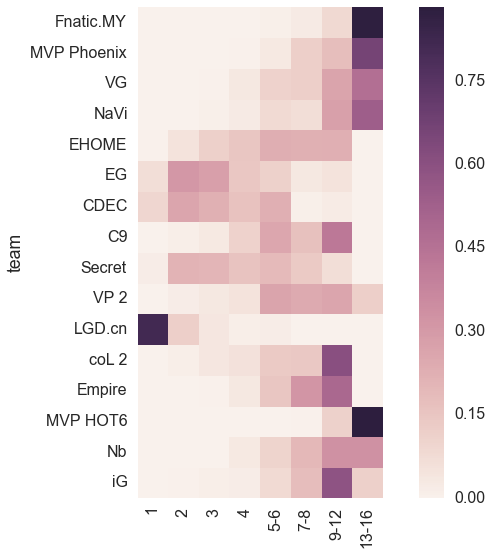

In [98]:
sns.heatmap(df_prob, square=True)

In [99]:
df_prob

,1,2,3,4,5-6,7-8,9-12,13-16
team,,,,,,,,
Fnatic.MY,0.0000,0.0000,0.0002,0.0013,0.0079,0.0256,0.0857,0.8793
MVP Phoenix,0.0000,0.0001,0.0006,0.0062,0.0289,0.1201,0.1768,0.6673
VG,0.0002,0.0006,0.0040,0.0368,0.1075,0.1197,0.2679,0.4633
NaVi,0.0001,0.0018,0.0071,0.0257,0.0799,0.0671,0.2816,0.5367
EHOME,0.0044,0.0490,0.1145,0.1497,0.2315,0.2219,0.2290,0.0000
EG,0.0657,0.3082,0.2844,0.1453,0.1116,0.0363,0.0485,0.0000
CDEC,0.0937,0.2623,0.2226,0.1638,0.2248,0.0090,0.0238,0.0000
C9,0.0002,0.0110,0.0302,0.1103,0.2560,0.1656,0.4267,0.0000
Secret,0.0193,0.2159,0.2066,0.1604,0.1900,0.1378,0.0700,0.0000


In [100]:
def likely_endings(df):
    df = df.cumsum(axis = 1)
    seen_teams = []
    
    first_place = df['1'].idxmax()
    seen_teams.append(first_place)
    mask = ~df.index.isin(seen_teams)
    
    second_place = df.loc[mask,'2'].idxmax()    
    seen_teams.append(second_place)
    mask = ~df.index.isin(seen_teams)
    
    third_place = df.loc[mask,'3'].idxmax()    
    seen_teams.append(third_place)
    mask = ~df.index.isin(seen_teams)
                          
    fourth_place = df.loc[mask,'4'].idxmax()    
    seen_teams.append(fourth_place)
    mask = ~df.index.isin(seen_teams)
    
    five_six_place = list(df_prob.loc[mask,'5-6'].order().tail(2).index.values)
    seen_teams = seen_teams + five_six_place
    mask = ~df.index.isin(seen_teams)
    
    seven_eight_place = list(df_prob.loc[mask,'7-8'].order().tail(2).index.values)
    seen_teams = seen_teams + seven_eight_place
    mask = ~df.index.isin(seen_teams)
    
    nine_twelve_place = list(df_prob.loc[mask,'9-12'].order().tail(4).index.values)
    seen_teams = seen_teams + nine_twelve_place
    mask = ~df.index.isin(seen_teams)
    
    thirt_six_place = list(df_prob.loc[mask,'13-16'].order().tail(4).index.values)
    
    print 'Winner: %s' % first_place
    print 'Runner Up: %s' % second_place
    print '3rd: %s' % third_place
    print '4th: %s' % fourth_place
    print '5-6: %s, %s' % tuple(five_six_place)
    print '7-8: %s, %s' % tuple(seven_eight_place)
    print '9-12: %s, %s, %s, %s' % tuple(nine_twelve_place)
    print '13-16: %s, %s, %s, %s' % tuple(thirt_six_place)
    

In [101]:
likely_endings(df_prob)

Winner: LGD.cn
Runner Up: EG
3rd: CDEC
4th: Secret
5-6: C9, VP 2
7-8: EHOME, Empire
9-12: NaVi, Nb, iG, coL 2
13-16: VG, MVP Phoenix, Fnatic.MY, MVP HOT6
